In [1]:
!pip install -U hydra-core plotly ipywidgets jupyter-dash blackcellmagic


     |████████████████████████████████| 145 kB 10.2 MB/s            
     |████████████████████████████████| 25.3 MB 43.1 MB/s            
     |████████████████████████████████| 112 kB 81.5 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 74 kB 61.6 MB/s            
     |████████████████████████████████| 7.3 MB 23.9 MB/s            
     |████████████████████████████████| 95 kB 72.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 155 kB 73.2 MB/s            
     |████████████████████████████████| 763 kB 55.1 MB/s            
     |████████████████████████████████| 120 kB 64.1 MB/s            
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 288 kB 46.4 MB/s            
     |████████████████████████████████| 357 kB 67.4 MB/s            
     |███████████████████████████████

In [63]:
import GetPoolData
from hydra import initialize, initialize_config_module, initialize_config_dir,compose

import pandas as pd
import numpy as np
import plotly.express as px

import requests

In [11]:
with initialize(config_path="./config"):
    cfg = compose(config_name="config", overrides=["strategy.DOWNLOAD_DATA=False"])
    print(cfg)

{'strategy': {'DOWNLOAD_DATA': False, 'address': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', 'token_0_address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'token_1_address': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2', 'flipside_queries': ['https://api.flipsidecrypto.com/api/v2/queries/b8ad3087-803a-478b-9ed3-c4f3c096bc47/data/latest', 'https://api.flipsidecrypto.com/api/v2/queries/de277680-5ff6-4d58-bfff-29ef114215be/data/latest'], 'price_data_begin': '2020-12-31', 'price_data_end': '2021-12-31', 'file_name': 'eth_usdc'}, 'BITQUERY_API_TOKEN': 'BQYNSx5vEIZ8XrxP72ViRpOM6qS1jGn0'}


/opt/conda/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [12]:
address, file_name = cfg.strategy.address, cfg.strategy.file_name
swap_data = GetPoolData.get_swap_data(address, file_name)  

#Cast datatypes
float_cols = ['amount0','amount1']
int_cols = ['tick']
time_cols = ['timestamp']

swap_data[float_cols] = swap_data[float_cols].astype(float)
swap_data[int_cols] = swap_data[int_cols].astype(int)

swap_data['datetime'] = pd.to_datetime(swap_data.timestamp,unit='s')
swap_data = swap_data.set_index('datetime').sort_index()

In [13]:
deltas = swap_data.index[1:] - swap_data.index[:-1]
time_between_swaps = deltas.map(lambda d: d.total_seconds()).to_series()

<AxesSubplot:ylabel='Density'>

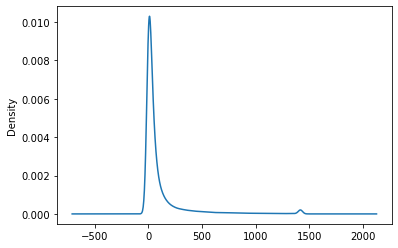

In [14]:
time_between_swaps.clip(upper=np.percentile(time_between_swaps,99)).plot.kde()

In [15]:
swap_data.head()

,amount0,amount1,amountUSD,id,tick,timestamp
datetime,,,,,,
2021-05-05 01:56:23,-0.329608,1.000000e-04,0,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,195285,1620179783
2021-05-05 08:23:26,-164.694492,5.000000e-02,82.65004407297800239663613789345355,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,195298,1620203006
2021-05-05 09:50:51,-0.329169,1.000000e-04,0.1650801110809307895034312593744575,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,195298,1620208251
2021-05-05 11:59:57,0.000002,-3.291690e-13,0.00000000054339110410000120819867998043187,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,195298,1620215997
2021-05-05 12:56:56,1559.137299,-4.678809e-01,772.3761772161907975533593003528345,0x67502d8ba373287f6d301f6baa77c5a5f4c80d0753c3...,195173,1620219416


In [16]:
swap_data = swap_data.drop('timestamp', axis=1)

In [17]:
swap_data['price0_1'] = swap_data.amount0.abs() / swap_data.amount1.abs()
swap_data['price1_0'] = swap_data.amount1.abs() / swap_data.amount0.abs()


In [18]:
swap_data.head()

,amount0,amount1,amountUSD,id,tick,price0_1,price1_0
datetime,,,,,,,
2021-05-05 01:56:23,-0.329608,1.000000e-04,0,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,195285,3.296080e+03,3.033907e-04
2021-05-05 08:23:26,-164.694492,5.000000e-02,82.65004407297800239663613789345355,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,195298,3.293890e+03,3.035924e-04
2021-05-05 09:50:51,-0.329169,1.000000e-04,0.1650801110809307895034312593744575,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,195298,3.291690e+03,3.037953e-04
2021-05-05 11:59:57,0.000002,-3.291690e-13,0.00000000054339110410000120819867998043187,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,195298,6.075906e+06,1.645845e-07
2021-05-05 12:56:56,1559.137299,-4.678809e-01,772.3761772161907975533593003528345,0x67502d8ba373287f6d301f6baa77c5a5f4c80d0753c3...,195173,3.332338e+03,3.000896e-04


In [15]:
cfg.strategy.flipside_queries

['https://api.flipsidecrypto.com/api/v2/queries/b8ad3087-803a-478b-9ed3-c4f3c096bc47/data/latest', 'https://api.flipsidecrypto.com/api/v2/queries/de277680-5ff6-4d58-bfff-29ef114215be/data/latest']

In [72]:
univ3_liquidity_queries = \
["https://api.flipsidecrypto.com/api/v2/queries/a16f9704-9abd-41b6-b2ef-528d10954240/data/latest",
 "https://api.flipsidecrypto.com/api/v2/queries/acde31f7-cba4-48bc-b896-f53544813c8c/data/latest"
]

In [73]:
dfs = []
for q in univ3_liquidity_queries:
    try:
        response = requests.get(q)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(f"HTTP Error {err}")
        break
    else:
        dfs.append(pd.DataFrame.from_records(response.json()))

In [76]:
df = pd.concat(dfs)
df['date'] = pd.to_datetime(df.BLOCK_TIMESTAMP, origin='unix')
df = df.set_index('date')

,BLOCKCHAIN,BLOCK_ID,BLOCK_TIMESTAMP,FEE_GROWTH_GLOBAL0_X128,FEE_GROWTH_GLOBAL1_X128,POOL_ADDRESS,POOL_NAME,PRICE_0_1,PRICE_1_0,PROTOCOL_FEES_TOKEN0_ADJUSTED,...,TOKEN1_BALANCE,TOKEN1_BALANCE_ADJUSTED,TOKEN1_BALANCE_USD,TOKEN1_SYMBOL,UNLOCKED,VIRTUAL_LIQUIDITY_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_USD,VIRTUAL_RESERVES_TOKEN1_ADJUSTED,VIRTUAL_RESERVES_TOKEN1_USD
date,,,,,,,,,,,,,,,,,,,,,
2021-11-26 19:14:45+00:00,ethereum,13691574,2021-11-26T19:14:45Z,1.400550e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4058.980921,0.000246,None,...,34987035749764749590528.0,34987.035750,1.478112e+08,WETH,True,8.270324e+06,5.268883e+08,5.267722e+08,129815.485773,5.484368e+08
2021-11-26 19:17:03+00:00,ethereum,13691583,2021-11-26T19:17:03Z,1.400580e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4062.635466,0.000246,None,...,34928508642278072385536.0,34928.508642,1.475639e+08,WETH,True,8.270324e+06,5.271259e+08,5.270098e+08,129756.958665,5.481896e+08
2021-11-26 19:17:46+00:00,ethereum,13691585,2021-11-26T19:17:46Z,1.400612e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4066.699930,0.000246,None,...,34864450395539733741568.0,34864.450396,1.472933e+08,WETH,True,8.270324e+06,5.273863e+08,5.272701e+08,129692.900419,5.479189e+08
2021-11-26 19:17:57+00:00,ethereum,13691586,2021-11-26T19:17:57Z,1.400612e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4066.699930,0.000246,None,...,34704182391817554100224.0,34704.182392,1.466162e+08,WETH,True,8.210490e+06,5.235708e+08,5.234554e+08,128754.608188,5.439549e+08
2021-11-26 19:18:13+00:00,ethereum,13691588,2021-11-26T19:18:13Z,1.400613e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4066.699930,0.000246,None,...,34702956076614029410304.0,34702.956077,1.466110e+08,WETH,True,8.210490e+06,5.235758e+08,5.234604e+08,128753.381873,5.439497e+08


In [78]:
df.to_csv("./data/flipside_liquidity_full.csv")

In [81]:
liquidity_df = pd.read_csv('./data/flipside_liquidity_full.csv', parse_dates=['date'], index_col=['date'])

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [83]:
liquidity_df.head()
liquidity_df.tail()

,BLOCKCHAIN,BLOCK_ID,BLOCK_TIMESTAMP,FEE_GROWTH_GLOBAL0_X128,FEE_GROWTH_GLOBAL1_X128,POOL_ADDRESS,POOL_NAME,PRICE_0_1,PRICE_1_0,PROTOCOL_FEES_TOKEN0_ADJUSTED,...,TOKEN1_BALANCE,TOKEN1_BALANCE_ADJUSTED,TOKEN1_BALANCE_USD,TOKEN1_SYMBOL,UNLOCKED,VIRTUAL_LIQUIDITY_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_USD,VIRTUAL_RESERVES_TOKEN1_ADJUSTED,VIRTUAL_RESERVES_TOKEN1_USD
date,,,,,,,,,,,,,,,,,,,,,
2021-11-26 19:14:45+00:00,ethereum,13691574,2021-11-26T19:14:45Z,1.400550e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4058.980921,0.000246,NaN,...,34987035749764749590528.0,34987.035750,1.478112e+08,WETH,True,8.270324e+06,5.268883e+08,5.267722e+08,129815.485773,5.484368e+08
2021-11-26 19:17:03+00:00,ethereum,13691583,2021-11-26T19:17:03Z,1.400580e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4062.635466,0.000246,NaN,...,34928508642278072385536.0,34928.508642,1.475639e+08,WETH,True,8.270324e+06,5.271259e+08,5.270098e+08,129756.958665,5.481896e+08
2021-11-26 19:17:46+00:00,ethereum,13691585,2021-11-26T19:17:46Z,1.400612e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4066.699930,0.000246,NaN,...,34864450395539733741568.0,34864.450396,1.472933e+08,WETH,True,8.270324e+06,5.273863e+08,5.272701e+08,129692.900419,5.479189e+08
2021-11-26 19:17:57+00:00,ethereum,13691586,2021-11-26T19:17:57Z,1.400612e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4066.699930,0.000246,NaN,...,34704182391817554100224.0,34704.182392,1.466162e+08,WETH,True,8.210490e+06,5.235708e+08,5.234554e+08,128754.608188,5.439549e+08
2021-11-26 19:18:13+00:00,ethereum,13691588,2021-11-26T19:18:13Z,1.400613e+33,5.025649e+41,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,4066.699930,0.000246,NaN,...,34702956076614029410304.0,34702.956077,1.466110e+08,WETH,True,8.210490e+06,5.235758e+08,5.234604e+08,128753.381873,5.439497e+08


In [85]:
virtual_cols = liquidity_df.filter(like='VIRTUAL', axis=1).columns.tolist()
gross_cols = liquidity_df.filter(regex='^TOKEN[0-1]_BALANCE*', axis=1).columns.tolist()
price_cols = ["PRICE_0_1", "PRICE_1_0"]
tick_cols = liquidity_df.filter(regex='.*TICK.*', axis=1).columns.tolist()
token_cols = liquidity_df.filter(like='SYMBOL', axis=1).columns.tolist()

In [87]:
columns_to_keep = gross_cols + virtual_cols + price_cols + tick_cols

In [88]:
df = liquidity_df[columns_to_keep]

In [90]:
df.head()

,TOKEN0_BALANCE,TOKEN0_BALANCE_ADJUSTED,TOKEN0_BALANCE_USD,TOKEN1_BALANCE,TOKEN1_BALANCE_ADJUSTED,TOKEN1_BALANCE_USD,VIRTUAL_LIQUIDITY_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_USD,VIRTUAL_RESERVES_TOKEN1_ADJUSTED,VIRTUAL_RESERVES_TOKEN1_USD,PRICE_0_1,PRICE_1_0,TICK
date,,,,,,,,,,,,,,
2021-05-04 23:10:00+00:00,0,0.000000,0.000000,9999999999999134,0.010000,33.472037,0.000000,0.000000,0.000000,0.000000,0.000000,3306.010571,0.000302,195285
2021-05-04 23:19:42+00:00,50000000000,50000.000000,49999.297168,9215484119256534000,9.215484,30846.102785,4303.369674,247434.796534,247431.318435,74.843922,250517.853852,3306.010571,0.000302,195285
2021-05-05 01:56:23+00:00,49999670392,49999.670392,49999.148198,9215584119256534000,9.215584,31015.058056,4303.369674,247434.466925,247431.882733,74.844021,251887.633057,3306.010571,0.000302,195285
2021-05-05 02:10:21+00:00,50167176347,50167.176347,50166.652404,9260333887159048000,9.260334,31165.663447,4533.355398,260658.149580,260655.427280,78.843923,265349.307033,3306.010571,0.000302,195285
2021-05-05 02:21:03+00:00,50167186347,50167.186347,50166.662403,9260336558692002000,9.260337,31165.672438,4533.369128,260658.939026,260656.216717,78.844162,265350.110687,3306.010571,0.000302,195285


In [91]:
df.tail()

,TOKEN0_BALANCE,TOKEN0_BALANCE_ADJUSTED,TOKEN0_BALANCE_USD,TOKEN1_BALANCE,TOKEN1_BALANCE_ADJUSTED,TOKEN1_BALANCE_USD,VIRTUAL_LIQUIDITY_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_ADJUSTED,VIRTUAL_RESERVES_TOKEN0_USD,VIRTUAL_RESERVES_TOKEN1_ADJUSTED,VIRTUAL_RESERVES_TOKEN1_USD,PRICE_0_1,PRICE_1_0,TICK
date,,,,,,,,,,,,,,
2021-11-26 19:14:45+00:00,79242081639771,7.924208e+07,7.922462e+07,34987035749764749590528.0,34987.035750,1.478112e+08,8.270324e+06,5.268883e+08,5.267722e+08,129815.485773,5.484368e+08,4058.980921,0.000246,193233
2021-11-26 19:17:03+00:00,79480450639771,7.948045e+07,7.946294e+07,34928508642278072385536.0,34928.508642,1.475639e+08,8.270324e+06,5.271259e+08,5.270098e+08,129756.958665,5.481896e+08,4062.635466,0.000246,193224
2021-11-26 19:17:46+00:00,79741593442834,7.974159e+07,7.972403e+07,34864450395539733741568.0,34864.450396,1.472933e+08,8.270324e+06,5.273863e+08,5.272701e+08,129692.900419,5.479189e+08,4066.699930,0.000246,193214
2021-11-26 19:17:57+00:00,79319285503779,7.931929e+07,7.930181e+07,34704182391817554100224.0,34704.182392,1.466162e+08,8.210490e+06,5.235708e+08,5.234554e+08,128754.608188,5.439549e+08,4066.699930,0.000246,193214
2021-11-26 19:18:13+00:00,79324287273779,7.932429e+07,7.930681e+07,34702956076614029410304.0,34702.956077,1.466110e+08,8.210490e+06,5.235758e+08,5.234604e+08,128753.381873,5.439497e+08,4066.699930,0.000246,193214
